In [75]:
import numpy as np
import pandas as pd
import os
np.object = object
np.bool = bool
np.int = int

In [76]:
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [130]:
adata = pd.read_csv("C:/Data/full_df.csv")
new_df = adata[(df['N'] == 1) | (df['G'] == 1) | (df['C'] == 1) | (df['A'] == 1) | (df['M'] == 1)]
new_df.head(20)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
7,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",8_right.jpg
11,13,60,Female,13_left.jpg,13_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",13_right.jpg
14,16,54,Female,16_left.jpg,16_right.jpg,normal fundus,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",16_right.jpg
16,18,58,Male,18_left.jpg,18_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",18_right.jpg
20,24,75,Female,24_left.jpg,24_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",24_right.jpg
29,35,68,Female,35_left.jpg,35_right.jpg,pathological myopia,normal fundus,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",35_right.jpg
34,43,35,Male,43_left.jpg,43_right.jpg,wet age-related macular degeneration,dry age-related macular degeneration，glaucoma,0,0,1,0,1,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['A'],"[0, 0, 0, 0, 1, 0, 0, 0]",43_right.jpg
37,46,66,Male,46_left.jpg,46_right.jpg,moderate non proliferative retinopathy,pathological myopia,0,1,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",46_right.jpg


In [114]:
def has_condn(term,text):
    if term in text:
        return 1
    else:
        return 0

In [134]:


def process_dataset(data):
    data["left_cataract"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))
    data["right_cataract"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))

    data["LG"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))
    data["RG"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))

    data["LM"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))
    data["RM"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))
    
    data["LA"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))
    data["RA"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))
    
    left_cataract_images = data.loc[(data.C ==1) & (data.left_cataract == 1)]["Left-Fundus"].values
    right_cataract_images = data.loc[(data.C == 1) & (data.right_cataract == 1)]["Right-Fundus"].values
    
    left_normal = data.loc[(data.C == 0) & (data["Left-Diagnostic Keywords"] == "normal fundus")]['Left-Fundus'].sample(350,random_state=42).values
    right_normal = data.loc[(data.C == 0) & (data["Right-Diagnostic Keywords"] == "normal fundus")]['Right-Fundus'].sample(350,random_state=42).values

    left_glaucoma = data.loc[(data.C == 0) & (data.LG == 1)]["Left-Fundus"].values
    right_glaucoma = data.loc[(data.C == 0) & (data.RG == 1)]["Right-Fundus"].values 
    
    left_myopia = data.loc[(data.C == 0) & (data.LM == 1)]["Left-Fundus"].values
    right_myopia = data.loc[(data.C == 0) & (data.RM == 1)]["Right-Fundus"].values 
    
    left_age = data.loc[(data.C == 0) & (data.LA == 1)]["Left-Fundus"].values
    right_age = data.loc[(data.C == 0) & (data.RA == 1)]["Right-Fundus"].values 
    
    normalones = np.concatenate((left_normal,right_normal),axis = 0);
    cataractones = np.concatenate((left_cataract_images,right_cataract_images),axis = 0);
    glaucoma = np.concatenate((left_glaucoma,right_glaucoma),axis = 0);
    myopia = np.concatenate((left_myopia,right_myopia),axis = 0);
    age = np.concatenate((left_age,right_age),axis=0);
    
    return normalones,cataractones,glaucoma,myopia,age;

In [138]:
normal , cataract , glaucoma , myopia , age = process_dataset(adata);

In [139]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "C:\Data\preprocessed_images"
image_size=224
labels = []
dataset = []
def dataset_generator(imagecategory , label):
    for img in tqdm(imagecategory):
        imgpath = os.path.join(dataset_dir,img);
        
        try:
            image = cv2.imread(imgpath,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue;
        dataset.append([np.array(image),np.array(label)]);
    random.shuffle(dataset);
    
    return dataset;

In [140]:
# Норма == 0
# Катаракта == 1
# Диабет == 2
# Глаукома == 3
# Гипертензия == 4
# Миопия == 5
# Возраст == 6
# Другое == 7

dataset = dataset_generator(normal,0)
dataset = dataset_generator(cataract,1)
dataset = dataset_generator(glaucoma,2)
dataset = dataset_generator(myopia,3)
dataset = dataset_generator(age,4)


len(dataset)

100%|██████████| 551/551 [00:01<00:00, 390.75it/s]


2919

In [150]:

train_x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3);
train_y = np.array([i[1] for i in dataset])

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
x_train , x_test , y_train, y_test = train_test_split(train_x,train_y, test_size=0.2)

y_train_cat = to_categorical(y_train,num_classes=5)

y_test_cat = to_categorical(y_test,num_classes = 5)

Создание модели

In [151]:
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

for layer in vgg.layers:
    layer.trainable = False


model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(5, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.01)))

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dense_18 (Dense)            (None, 256)               6422784   
                                                                 
 batch_normalization_12 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_19 (Dense)            (None, 256)               65792     
                                                                 
 batch_normalization_13 (Bat  (None, 256)              1024      
 chNormalization)                                     

In [152]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

history = model.fit(x_train,y_train_cat,batch_size=32,epochs=10)
print(history)

Epoch 1/10
73/73 [==============================] - 190s 3s/step - loss: 0.8874 - accuracy: 0.6797
Epoch 2/10
73/73 [==============================] - 187s 3s/step - loss: 0.3616 - accuracy: 0.8758
Epoch 3/10
73/73 [==============================] - 191s 3s/step - loss: 0.2356 - accuracy: 0.9276
Epoch 4/10
73/73 [==============================] - 193s 3s/step - loss: 0.1579 - accuracy: 0.9555
Epoch 5/10
73/73 [==============================] - 192s 3s/step - loss: 0.1159 - accuracy: 0.9657
Epoch 6/10
73/73 [==============================] - 192s 3s/step - loss: 0.1089 - accuracy: 0.9666
Epoch 7/10
73/73 [==============================] - 192s 3s/step - loss: 0.0910 - accuracy: 0.9730
Epoch 8/10
73/73 [==============================] - 192s 3s/step - loss: 0.0820 - accuracy: 0.9726
Epoch 9/10
73/73 [==============================] - 192s 3s/step - loss: 0.0884 - accuracy: 0.9700
Epoch 10/10
73/73 [==============================] - 192s 3s/step - loss: 0.0703 - accuracy: 0.9760


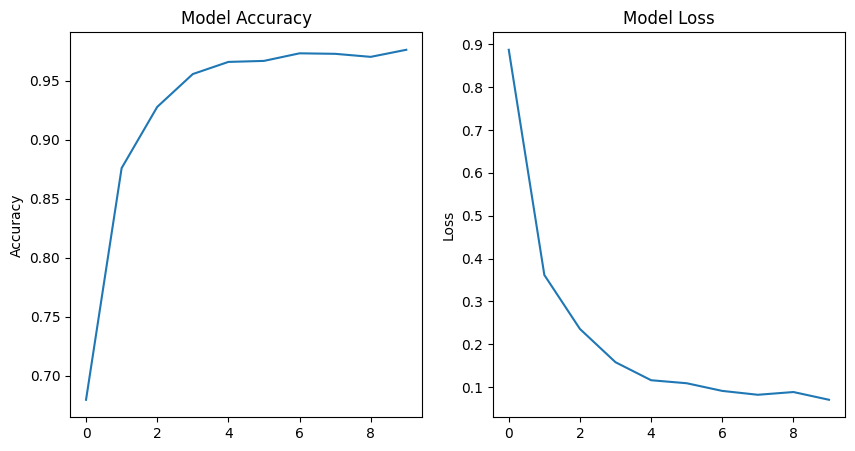

In [153]:
import matplotlib.pyplot as plt

# Plot all metrics
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(model.history.history['accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set(ylabel='Accuracy')

axs[1].plot(model.history.history['loss'])
axs[1].set_title('Model Loss')
axs[1].set(ylabel='Loss')


plt.show()

In [166]:
loss,accuracy = model.evaluate(x_test,y_test_cat)
print("Accuracy:",accuracy)

19/19 [==============================] - 49s 3s/step - loss: 0.6355 - accuracy: 0.8253
Accuracy: 0.8253424763679504


In [155]:
from sklearn.metrics import confusion_matrix,accuracy_score

y_pred = []
for i in model.predict(x_test):
    y_pred.append(np.argmax(np.array(i)).astype("int32"))

print(y_pred)

19/19 [==============================] - 46s 2s/step
[4, 1, 1, 4, 0, 2, 3, 1, 0, 4, 4, 4, 2, 3, 4, 4, 0, 4, 3, 2, 1, 2, 0, 4, 3, 0, 4, 3, 3, 3, 2, 4, 3, 2, 2, 1, 4, 0, 3, 1, 3, 1, 3, 1, 4, 4, 0, 4, 4, 4, 1, 4, 0, 4, 0, 2, 1, 2, 1, 0, 2, 1, 2, 2, 0, 1, 2, 0, 0, 0, 1, 2, 0, 4, 3, 0, 0, 3, 1, 2, 3, 3, 0, 4, 2, 2, 3, 2, 2, 1, 2, 2, 1, 0, 2, 1, 1, 0, 3, 4, 0, 4, 2, 1, 2, 4, 3, 0, 2, 3, 2, 3, 2, 0, 2, 0, 4, 0, 3, 0, 4, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 0, 4, 4, 1, 2, 0, 2, 1, 0, 1, 1, 2, 1, 0, 1, 2, 1, 1, 1, 1, 0, 2, 1, 1, 3, 0, 3, 2, 2, 1, 4, 4, 4, 0, 1, 2, 0, 4, 3, 0, 2, 1, 2, 0, 4, 2, 4, 0, 2, 1, 2, 2, 1, 3, 4, 3, 1, 2, 2, 1, 4, 4, 2, 3, 0, 3, 2, 3, 3, 0, 1, 3, 1, 1, 2, 2, 0, 4, 4, 3, 0, 3, 3, 4, 2, 1, 2, 0, 4, 1, 1, 1, 2, 2, 3, 2, 4, 1, 0, 4, 1, 1, 1, 1, 2, 3, 2, 0, 0, 1, 4, 1, 4, 3, 3, 0, 3, 1, 0, 4, 4, 1, 2, 3, 0, 4, 3, 0, 3, 1, 0, 2, 4, 3, 1, 2, 2, 2, 2, 4, 0, 4, 1, 1, 0, 1, 1, 2, 1, 0, 0, 1, 4, 1, 2, 4, 2, 0, 2, 1, 2, 2, 2, 0, 2, 3, 1, 2, 1, 0, 2, 3, 2, 2, 2, 1, 3, 2, 0, 2, 1, 2

In [156]:
print(accuracy_score(y_test,y_pred))

0.8253424657534246


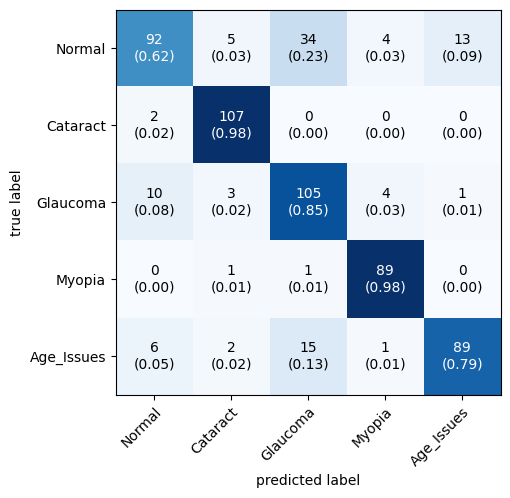

In [164]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(5,5),class_names = ["Normal","Cataract","Glaucoma","Myopia","Age_Issues"],show_normed = True);

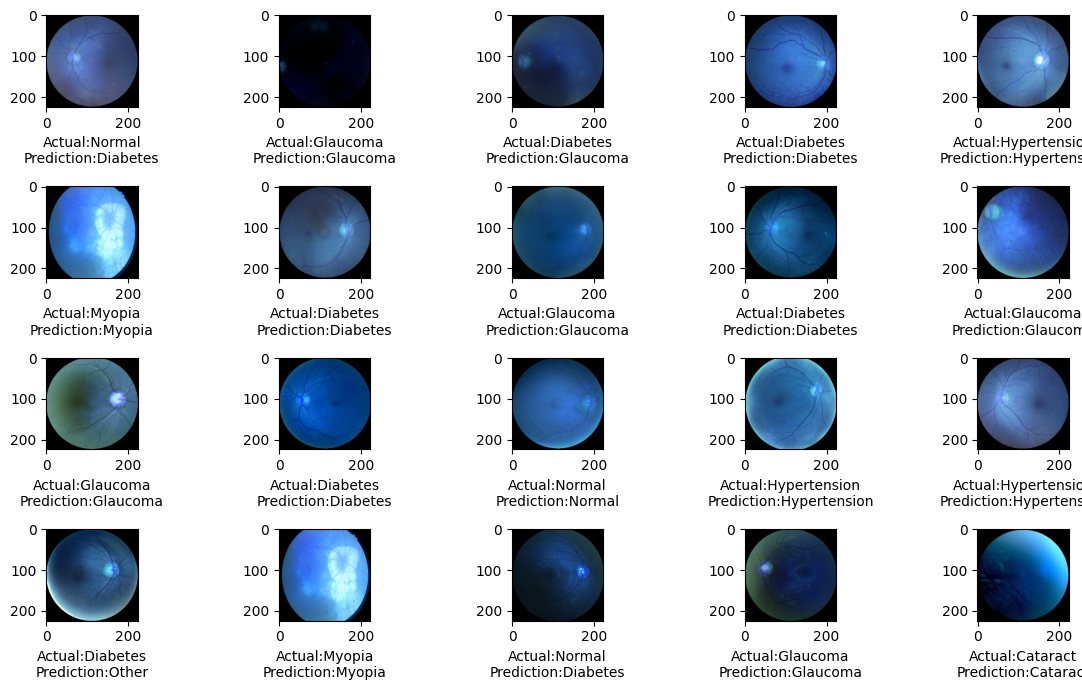

In [ ]:
plt.figure(figsize=(12,7))
for i in range(20):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    elif category == 1 :
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Hypertension"
    elif category == 5:
        label = "Myopia"
    elif category == 6:
        label = "Age Issues"
    else:
        label = "Other"
        
    if pred_category== 0:
        pred_label = "Normal"
    elif pred_category == 1 :
        pred_label = "Cataract"
    elif pred_category == 2:
        pred_label = "Diabetes"
    elif pred_category == 3:
        pred_label = "Glaucoma"
    elif pred_category == 4:
        pred_label = "Hypertension"
    elif pred_category == 5:
        pred_label = "Myopia"
    elif pred_category == 6:
        pred_label = "Age Issues"
    else:
        pred_label = "Other"
        
    plt.subplot(4,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 

In [ ]:
from tensorflow.keras.models import load_model

model.save('C:\Data\ModelEyes.h5')


1


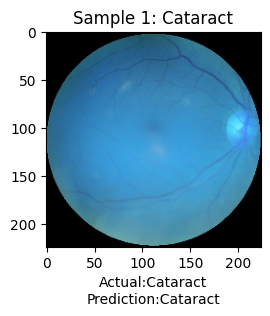

In [ ]:
plt.figure(figsize=(12,12))
for i in range(1):
    sample = 1
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    elif category == 1 :
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Hypertension"
    elif category == 5:
        label = "Myopia"
    elif category == 6:
        label = "Age Issues"
    else:
        label = "Other"
        
    if pred_category== 0:
        pred_label = "Normal"
    elif pred_category == 1 :
        pred_label = "Cataract"
    elif pred_category == 2:
        pred_label = "Diabetes"
    elif pred_category == 3:
        pred_label = "Glaucoma"
    elif pred_category == 4:
        pred_label = "Hypertension"
    elif pred_category == 5:
        pred_label = "Myopia"
    elif pred_category == 6:
        pred_label = "Age Issues"
    else:
        pred_label = "Other"
        
    plt.subplot(4,5,i+1)
    plt.imshow(image)
    plt.title("Sample {}: {}".format(sample, label))
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 
print(sample)

In [ ]:
data = pd.read_csv("C:/Data/full_df.csv")
# Выводим только строки, у которых в столбце "C" стоит 1
filtered_data = data[data['C'] == 1]
print(filtered_data.head(50))

        ID  Patient Age Patient Sex    Left-Fundus    Right-Fundus  \
0        0           69      Female     0_left.jpg     0_right.jpg   
20      24           75      Female    24_left.jpg    24_right.jpg   
65      81           66        Male    81_left.jpg    81_right.jpg   
86     103           55      Female   103_left.jpg   103_right.jpg   
93     112           57      Female   112_left.jpg   112_right.jpg   
100    119           59        Male   119_left.jpg   119_right.jpg   
160    188           55      Female   188_left.jpg   188_right.jpg   
186    218           36      Female   218_left.jpg   218_right.jpg   
218    254           60      Female   254_left.jpg   254_right.jpg   
256    294           69      Female   294_left.jpg   294_right.jpg   
287    330           65      Female   330_left.jpg   330_right.jpg   
301    345           64      Female   345_left.jpg   345_right.jpg   
309    354           65        Male   354_left.jpg   354_right.jpg   
391    448          